 Copyright © Sorbonne University.

 This source code is licensed under the MIT license found in the
 LICENSE file in the root directory of this source tree.

# Outlook

In this notebook we will study basic reinforcement learning
algorithms: TD learning, Q-learning and SARSA. We will also investigate two
basic exploration strategies: $\epsilon$-greedy and softmax.


## Initialization

We begin by loading all the modules necessary for this notebook.

In [1]:
try:
    from easypip import easyimport
except ModuleNotFoundError:
    from subprocess import run
    assert run(["pip", "install", "easypip"]).returncode == 0, "Could not install easypip"
    from easypip import easyimport

easyimport("swig")
easyimport("bbrl_utils").setup(maze_mdp=True)

import os
from pathlib import Path
from typing import List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from bbrl_gymnasium.envs.maze_mdp import MazeMDPEnv
from bbrl_utils.notebook import tqdm
from mazemdp.mdp import Mdp
from mazemdp.toolbox import egreedy, egreedy_loc, sample_categorical, softmax
from mazemdp import random_policy
import bbrl_gymnasium  # noqa: F401

# Settings
NB_EPISODES = 100
TIMEOUT = 25

Matplotlib backend: module://matplotlib_inline.backend_inline


c:\Users\asola\.conda\envs\deepdac\lib\site-packages\bbrl_utils\notebook.py:46: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm  # noqa: F401


# Reinforcement Learning

Reinforcement Learning is about finding the optimal policy in an MDP which is
initially unknown to the agent. More precisely, the state and action spaces
are known, but the agent does not know the transition and reward functions.
Generally speaking, the agent has to explore the MDP to figure out which
action in which state leads to which other state and reward. The model-free
case is about finding this optimal policy just through very local updates,
without storing any information about previous interactions with the
environment. Principles of these local updates can already be found in the
Temporal Difference (TD) algorithm, which iteratively computes optimal values
for all state using local updates. The most widely used model-free RL
algorithms are **q-learning**, **SARSA** and **actor-critic** algorithms.

As for dynamic programming, we first create a maze-like MDP. Reinforcement
learning is slower than dynamic programming, so we will work with smaller
mazes.

In [2]:
import gymnasium as gym

# Environment with 20% of walls and no negative reward when hitting a wall
env = gym.make(
    "MazeMDP-v0",
    kwargs={"width": 4, "height": 3, "ratio": 0.2, "hit": 0.0},
    render_mode="human",
)
env.reset()
env.unwrapped.init_draw("The maze")

       [ 1,  4, -1,  8],
       [ 2,  5,  7,  9]]), t…

# Temporal Difference (TD) learning ##

Given a state and an action spaces as well as a policy, TD(0) computes the
state value of this policy based on the following equations: 

$$\delta_t = r(s_t,a_t) + \gamma V^{(i)}(s_{t+1})-V^{(i)}(s_t)$$
$$V^{(i+1)}(s_t) = V^{(i)}(s_t) + \alpha\delta_t$$

where $\delta$ is the TD error and $\alpha$ is a parameter called "learning
rate".

The code is provided below, so that you can take inspiration later on. The
important part is the computation of $\delta$, and the update of the values of
$V$.

To run TD learning, a policy is needed as input. Such a policy can be
retreived by using the `policy_iteration_q(mdp)` function defined in the
dynamic programming notebook.

If you want to run this notebook independently, you can use instead the
`random_policy` provided in `mazemdp`. This is what we do here by default,
replace it if you want to run TD learning from an optimal policy.

The ```evaluate``` function below is not necessary for the lab, it is left here for its informative value.

In [3]:
def evaluate(mdp, policy):
    x, _ = mdp.reset(uniform=True)
    done = False
    reward = 0

    while not done:
        # Perform a step of the MDP
        u = sample_categorical(policy[x])
        _, r, done, *_ = mdp.step(u)
        reward += r
    return reward

**Question:** In the code of the *temporal_difference(...)* function below,
fill the missing parts

In [4]:
def temporal_difference(
    mdp: MazeMDPEnv,
    policy: np.ndarray,
    nb_episodes: int = 50,
    alpha: float = 0.2,
    timeout: int = 25,
    render: bool = True,
) -> np.ndarray:
    # alpha: learning rate
    # timeout: timeout of an episode (maximum number of timesteps)
    v = np.zeros(mdp.unwrapped.nb_states)  # initial state value v
    mdp.timeout = timeout

    if render:
        mdp.unwrapped.init_draw("Temporal differences")

    for _ in tqdm(range(nb_episodes)):  # for each episode

        # Draw an initial state randomly (if uniform is set to False, the state
        # is drawn according to the P0 distribution)
        x, _ = mdp.reset(uniform=True)
        terminated = False
        truncated = False
        while not (terminated or truncated):
            # Show agent
            if render:
                mdp.unwrapped.draw_v_pi(v, policy)

            # Step forward following the MDP: x=current state, pol[i]=agent's
            # action according to policy pol, r=reward gained after taking
            # action pol[i], terminated=tells whether  the episode ended, and info
            # gives some info about the process
            y, r, terminated, truncated, _ = mdp.step(
                egreedy_loc(policy[x], mdp.action_space.n, epsilon=0.2)
            )
            # To be completed...

            # Update the state value of x
            delta = r + mdp.gamma * v[y] - v[x]
            v[x] = v[x] + alpha * delta


            # Update agent's position (state)
            x = y

    if render:
        mdp.current_state = 0
        mdp.unwrapped.draw_v_pi(v, policy)
    return v

Once this is done, you can run it.

In [5]:
policy = random_policy(env)
v = temporal_difference(env, policy, nb_episodes=10, timeout=TIMEOUT)

       [ 1,  3,  5,  8],
       [-1,  4,  6,  9]]), t…

  0%|          | 0/10 [00:00<?, ?it/s]

Unless you were lucky, the generated value function is boring: if the policy
does not reach the final state, all values are 0. To avoid this, you can
copy-paste a dynamic programming function on the Q function from the previous
notebook, use it to get an optimal policy, and use this policy for TD
learning. You should get a much more interesting value function.

In [6]:
# Put your code to obtain an optimal Q function here

def value_iteration_v(
    mdp: MazeMDPEnv, render: bool = True
) -> Tuple[np.ndarray, List[float]]:
    # Value Iteration using the state value v
    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    v_list = []
    stop = False

    mdp.init_draw("Value iteration V")

    mdp.draw_v(v)

    while not stop:
        v_old = v.copy()
        mdp.draw_v(v)

        for x in range(mdp.nb_states):  # for each state x
            # Compute the value of the state x for each action u of the MDP action space
            if x in mdp.terminal_states:
                v[x] = np.max(mdp.r[x, :])
            else:
                v_temp = []
                for u in range(mdp.action_space.n):
                    # Process sum of the values of the neighbouring states
                    summ = 0
                    for y in range(mdp.nb_states):
                        summ = summ + mdp.P[x, u, y] * v_old[y]
                    v_temp.append(mdp.r[x, u] + mdp.gamma * summ)

                # Select the highest state value among those computed
                v[x] = np.max(v_temp)

        # Test if convergence has been reached
        if (np.linalg.norm(v - v_old)) < 0.01:
            stop = True
        v_list.append(np.linalg.norm(v))

    policy = get_policy_from_v(mdp, v)
    mdp.draw_v_pi(v, policy)
    return v, v_list

In [7]:
# Put your code to get a policy from a Q function here

def get_policy_from_v(mdp: MazeMDPEnv, v: np.ndarray) -> np.ndarray:
    """Outputs a policy given the state values"""

    # Sets initial state values are set to 0
    policy = np.zeros(mdp.nb_states)  

    # Loop over MDP states
    for x in range(mdp.nb_states):
        if x in mdp.terminal_states:
            # Takes the reward associated with the terminal state
            policy[x] = np.argmax(mdp.r[x, :])
        else:
            # Compute the value V(x) for state x
            v_temp = []
            
            # Loop over actions
            for u in range(mdp.action_space.n):
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    summ = summ + mdp.P[x, u, y] * v[y]
                v_temp.append(mdp.r[x, u] + mdp.gamma * summ)
            policy[x] = np.argmax(v_temp)
    return policy


In [8]:
# Put your code to run the algorithm here

v = value_iteration_v(env)
policy = get_policy_from_v(env, v)
v = temporal_difference(env, policy, nb_episodes=10, timeout=TIMEOUT)

       [ 1,  3,  5,  8],
       [-1,  4,  6,  9]]), t…

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

# Q-learning ##

The **q-learning** algorithm accounts for an agent exploring an MDP and
updating at each step a model of the state action-value function stored into a
Q-table. It is updated as follows:

$$
\delta_t = \left( r(s_t,a_t) + \gamma \max_{a \in A}
Q^{(i)}(s_{t+1},a) \right) -Q^{(i)}(s_t,a_t)
$$

$$Q^{(i+1)}(s_t, a_t) = Q^{(i)}(s_t,a_t) + \alpha \delta_t$$

To visualize the policy, we need the `get_policy_from_q(q)` function that we defined in the
dynamic programming notebook. If you have not done so yet, import it below.

In [11]:
# Put your code here
def value_iteration_q(
    mdp: MazeMDPEnv, render: bool = True
) -> Tuple[np.ndarray, List[float]]:
    q = np.zeros(
        (mdp.nb_states, mdp.action_space.n)
    )  # initial action values are set to 0
    q_list = []
    stop = False

    mdp.init_draw("Value iteration Q")

    mdp.draw_v(q)

    while not stop:
        qold = q.copy()

        mdp.draw_v(q)

        for x in range(mdp.nb_states):
            for u in range(mdp.action_space.n):
                if x in mdp.terminal_states:
                    q[x, u] = mdp.r[x, u]
                else:
                    summ = 0
                    for y in range(mdp.nb_states):
                        summ += mdp.P[x, u, y] * np.max(qold[y, :]) 

                    # Compléter d'après la formule ci-dessus
                    q[x, u] = mdp.r[x, u] + mdp.gamma * summ


        if (np.linalg.norm(q - qold)) <= 0.01:
            stop = True
        q_list.append(np.linalg.norm(q))

    mdp.draw_v(q)

    return q, q_list

def get_policy_from_q(q: np.ndarray) -> np.ndarray:
    # Outputs a policy given the action values
    
    return np.array([np.argmax(value) for value in q])

Fill the code of the `q_learning(...)` function below.

In [12]:
# --------------------------- Q-Learning epsilon-greedy version -------------------------------#
# Given an exploration rate epsilon, the QLearning algorithm computes the state action-value function
# based on an epsilon-greedy policy
# alpha is the learning rate


def q_learning_eps(
    mdp: MazeMDPEnv,
    epsilon: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    render: bool = True,
    init_q: float = 0.0,
    uniform: bool = True,
) -> Tuple[np.ndarray, List[float]]:
    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.n))
    q[:, :] = init_q
    q_list = []
    time_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    if render:
        mdp.init_draw("Q Learning")

    for _ in range(nb_episodes):
        # Draw the first state of episode i using a uniform distribution over all the states
        x, _ = mdp.reset(uniform=uniform)
        cpt = 0

        terminated = False
        truncated = False
        while not (terminated or truncated):
            # Show the agent in the maze
            if render:
                mdp.draw_v_pi(q, q.argmax(axis=1))

            # Draw an action using an epsilon-greedy policy
            u = egreedy(q, x, epsilon)

            # Perform a step of the MDP
            y, r, terminated, truncated, _ = mdp.step(u)

            # To be completed...

            # Update the state-action value function with q-Learning
            delta = r + mdp.gamma * (1-terminated) * max(q[y,:]) - q[x, u]
            q[x, u] += alpha * delta


            # Update the agent position
            x = y
            cpt = cpt + 1

        q_list.append(np.linalg.norm(np.maximum(q, q_min)))
        time_list.append(cpt)

    if render:
        mdp.current_state = 0
        mdp.draw_v_pi(q, get_policy_from_q(q))

    return q, q_list, time_list

And run it.

In [13]:
epsilon = 0.02
q, q_list, time_list = q_learning_eps(
    env, epsilon, nb_episodes=NB_EPISODES, timeout=TIMEOUT
)

       [ 1,  3,  5,  8],
       [-1,  4,  6,  9]]), t…

## Harder case: fixed starting point and exploration

We now explore the case where the agent always start at the *beginning of the maze* (`uniform=False`), corresponding to the top-left corner when this is a free cell.

In [14]:
epsilon = 0.02
start_q, start_q_list, time_list = q_learning_eps(
    env, epsilon, nb_episodes=NB_EPISODES, timeout=TIMEOUT, uniform=False
)

       [ 1,  3,  5,  8],
       [-1,  4,  6,  9]]), t…

You will observe that it is very difficult for the agent to learn to reach the
final state (and the larger the maze, the more difficult). A simple trick to
avoid this is to initialize the value of each $(s,a)$ pair to a small (lower
than the final reward) value. Try it with the example above !

In [15]:
# To be completed...

# Put your code to run q_learning_eps here



### Learning dynamics

By watching carefully the values while the agent is learning, you can see that
the agent favors certains paths over others which have a strictly equivalent value.
This can be explained easily: as the agent chooses a path for the first
time, it updates the values along that path, these values get higher than the
surrounding values, and the agent chooses the same path again and again,
increasing the phenomenon. Only steps of random exploration can counterbalance
this effect, but they do so extremely slowly.

### Exploration

In the `q_learning(...)` function above, action selection is based on a
$\epsilon$-greedy policy. Instead, it could have relied on *`softmax`*.

In the function below, you have to replace the call to the
previous *$\epsilon$-greedy* policy with a `softmax` policy. The
`softmax(...)` and `egreedy(...)` functions are available in
`mazemdp.toolbox`.

`sofmax(...)` returns a distribution probability over actions. To sample
an action according to their probabilities, you can use the
`sample_categorical` function.

In [16]:
# --------------------------- Q-Learning softmax version ----------------------------#
# Given a temperature "beta", the QLearning algorithm computes the state action-value function
# based on a softmax policy
# alpha is the learning rate


def q_learning_soft(
    mdp: MazeMDPEnv,
    beta: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    render: bool = True,
) -> Tuple[np.ndarray, List[float]]:
    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_list = []
    time_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    if render:
        mdp.init_draw("Q Learning (Softmax)")

    for _ in range(nb_episodes):
        # Draw the first state of episode i using a uniform distribution over all the states
        x, _ = mdp.reset(uniform=True)
        cpt = 0

        terminated = False
        truncated = False
        while not (terminated or truncated):
            if render:
                mdp.draw_v_pi(q, q.argmax(axis=1))

            # To be completed...

            # Draw an action using a soft-max policy
            u = sample_categorical(softmax(q, x, 1/6)) # (here, call the softmax function)


            # To be completed...

            # Copy-paste the rest from q_learning_eps
             # Perform a step of the MDP
            y, r, terminated, truncated, _ = mdp.step(u)

            # To be completed...

            # Update the state-action value function with q-Learning
            delta = r + mdp.gamma * (1-terminated) * max(q[y,:]) - q[x, u]
            q[x, u] += alpha * delta


            x = y
            cpt = cpt + 1

        q_list.append(np.linalg.norm(np.maximum(q, q_min)))
        time_list.append(cpt)

    if render:
        mdp.current_state = 0
        mdp.draw_v_pi(q, get_policy_from_q(q))

    return q, q_list, time_list

 Run this new version

In [17]:
NB_EPISODES = 40
beta = 6
q, q_list, time_list = q_learning_soft(
    env, beta, nb_episodes=NB_EPISODES, timeout=TIMEOUT
)

       [ 1,  3,  5,  8],
       [-1,  4,  6,  9]]), t…

# Sarsa

The **sarsa** algorithm is very similar to **q-learning**. At first glance,
the only difference is in the update rule. However, to perform the update in
**sarsa**, one needs to know the action the agent will take when it will be at
the next state, even if the agent is taking a random action.

This implies that the next state action is determined in advance and stored
for being played at the next time step.

The update formula is as follows: 

$$ \delta_t = \left( r(s_t,a_t) + \gamma Q^{(i)}(s_{t+1}, a_{t+1})
\right) -Q^{(i)}(s_t,a_t) $$

$$ Q^{(i+1)}(s_t,a_t) = Q^{(i)}(s_t,a_t) + \alpha \delta_t $$ 



## SARSA ($\epsilon-greedy$ version)
Fill the code below

In [18]:
# Given an exploration rate epsilon, the SARSA algorithm computes the state action-value function
# based on an epsilon-greedy policy
# alpha is the learning rate


def sarsa_eps(
    mdp: MazeMDPEnv,
    epsilon: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    render: bool = True,
) -> Tuple[np.ndarray, List[float]]:
    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_list = []
    time_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    if render:
        mdp.init_draw("Sarsa e-greedy")

    for _ in range(nb_episodes):
        # Draw the first state of episode i using a uniform distribution over all the states
        x, _ = mdp.reset(uniform=True)
        u = egreedy(q, x, epsilon)
        cpt = 0
        
        # To be completed...

        # Fill this part of the code
        terminated = False
        truncated = False
        while not (terminated or truncated):
            if render:
                mdp.draw_v_pi(q, q.argmax(axis=1))


            # To be completed...

            # Copy-paste the rest from q_learning_eps
             # Perform a step of the MDP
            y, r, terminated, truncated, _ = mdp.step(u)
            v = egreedy(q, y, epsilon)
            # To be completed...

            # Update the state-action value function with q-Learning
            delta = r + mdp.gamma * (1-terminated) * q[y, v] - q[x, u]
            q[x, u] += alpha * delta


            x = y
            u = v
            cpt = cpt + 1

        q_list.append(np.linalg.norm(np.maximum(q, q_min)))
        time_list.append(cpt)

    if render:
        mdp.current_state = 0
        mdp.draw_v_pi(q, get_policy_from_q(q))
    return q, q_list, time_list

And run it.

In [19]:
epsilon = 0.02
q, q_list, time_list = sarsa_eps(env, epsilon, nb_episodes=NB_EPISODES, timeout=TIMEOUT)

       [ 1,  3,  5,  8],
       [-1,  4,  6,  9]]), t…

As for **q-learning** above, copy-paste the resulting code to get a
*sarsa_soft(...)* and a *sarsa_eps(...)* function.

In [20]:
# --------------------------- Sarsa, softmax version -------------------------------#
# Given a temperature "beta", the SARSA algorithm computes the state action-value function
# based on a softmax policy
# alpha is the learning rate


def sarsa_soft(
    mdp: MazeMDPEnv,
    beta: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    render: bool = True,
) -> Tuple[np.ndarray, List[float]]:

    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_list = []
    time_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    if render:
        mdp.init_draw("Sarsa (Softmax)")

    for _ in range(nb_episodes):
        # Draw the first state of episode i using a uniform distribution over all the states
        x, _ = mdp.reset(uniform=True)
        u = sample_categorical(softmax(q, x, 1/6))
        cpt = 0
        
        # To be completed...

        # Fill this part of the code
        terminated = False
        truncated = False
        while not (terminated or truncated):
            if render:
                mdp.draw_v_pi(q, q.argmax(axis=1))


            # To be completed...

            # Copy-paste the rest from q_learning_eps
             # Perform a step of the MDP
            y, r, terminated, truncated, _ = mdp.step(u)
            v = sample_categorical(softmax(q, y, 1/6))
            # To be completed...

            # Update the state-action value function with q-Learning
            delta = r + mdp.gamma * (1-terminated) * q[y, v] - q[x, u]
            q[x, u] += alpha * delta


            x = y
            u = v
            cpt = cpt + 1


        q_list.append(np.linalg.norm(np.maximum(q, q_min)))
        time_list.append(cpt)

    if render:
        mdp.current_state = 0
        mdp.draw_v_pi(q, get_policy_from_q(q))
    return q, q_list, time_list

And run it.

In [21]:
# To be completed...

# Put your code to run sarsa_soft here
epsilon = 0.02
q, q_list, time_list = sarsa_soft(env, epsilon, nb_episodes=NB_EPISODES, timeout=TIMEOUT)


       [ 1,  3,  5,  8],
       [-1,  4,  6,  9]]), t…

## Study part
### Impact of `epsilon` and `beta` on q-learning and sarsa

Compare the number of steps needed by **q-learning** and **sarsa** to converge
on a given MDP using the *softmax* and *$\epsilon$-greedy* exploration
strategies. To figure out, you can use the provided `plot_ql_sarsa(m, epsilon,
beta, nb_episodes, timeout, alpha, render)` function below with various values
for $\epsilon$ (e.g. 0.001, 0.01, 0.1) and $\beta$ (e.g. 0.1, 5, 10) and
comment the obtained curves. Other visualizations are welcome.

Note that instead of the temperature `beta`, computational neuroscience
researchers, who generally prefer softmax exploration, use a parameter `beta`
which behaves as an inverse of the temperature. That way, the three
hyper-parameters of basic tabular RL algorithms are `alpha`, `beta`, and
`gamma`.

In [22]:
# -------- plot learning curves of Q-Learning and Sarsa using epsilon-greedy and softmax ----------#
def plot_ql_sarsa(env, epsilon, beta, nb_episodes, timeout, alpha, render):
    q, q_list1, time_list1 = q_learning_eps(
        env, epsilon, nb_episodes, timeout, alpha, render
    )
    q, q_list2, time_list2 = q_learning_soft(
        env, beta, nb_episodes, timeout, alpha, render
    )
    q, q_list3, time_list3 = sarsa_eps(
        env, epsilon, nb_episodes, timeout, alpha, render
    )
    q, q_list4, time_list4 = sarsa_soft(env, beta, nb_episodes, timeout, alpha, render)

    plt.clf()
    plt.plot(range(len(q_list1)), q_list1, label="q-learning e-greedy")
    plt.plot(range(len(q_list2)), q_list2, label="q-learning softmax")
    plt.plot(range(len(q_list3)), q_list3, label="sarsa e-greedy")
    plt.plot(range(len(q_list4)), q_list4, label="sarsa softmax")

    plt.xlabel("Number of episodes")
    plt.ylabel("Norm of Q values")
    plt.legend(loc="upper right")
    # plt.savefig("comparison_RL.png")
    plt.title("Comparison of convergence rates")
    plt.show()

    plt.clf()
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(time_list1)), time_list1, label="qlearning e-greedy")
    plt.plot(range(len(time_list2)), time_list2, label="qlearning softmax")
    plt.plot(range(len(time_list3)), time_list3, label="sarsa e-greedy")
    plt.plot(range(len(time_list4)), time_list4, label="sarsa softmax")

    plt.xlabel("Number of episodes")
    plt.ylabel("Steps to reach goal")
    plt.legend(loc="upper right")
    # plt.savefig("comparison_RL.png")
    plt.title("test")
    plt.show()

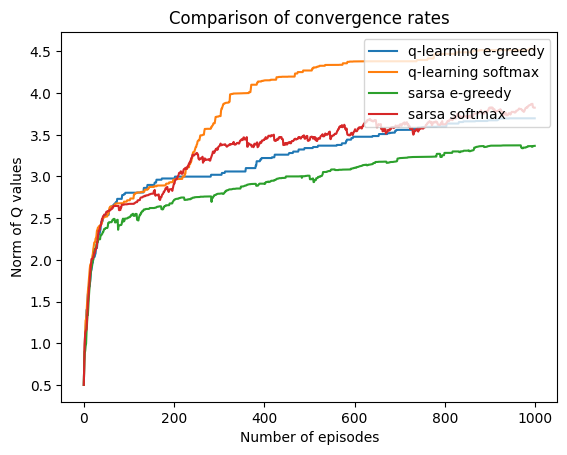

<Figure size 640x480 with 0 Axes>

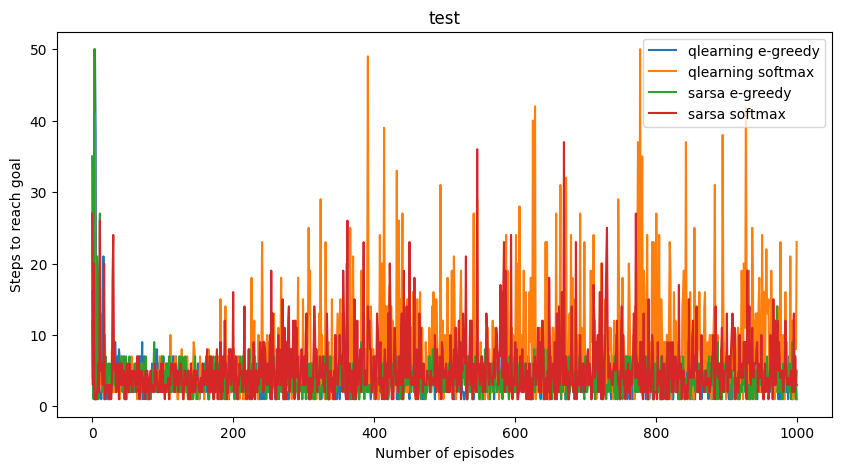

In [23]:
# example
plot_ql_sarsa(
    env, epsilon=0.02, beta=6, nb_episodes=1000, timeout=100, alpha=0.5, render=False
)

### Effect of hyper-parameters

The other two hyper-parameters of **q-learning** and **sarsa** are $\alpha$,
and $\gamma$. By varying the values of these hyper-parameters and watching the
learning process and behavior of the agent, explain their impact on the
algorithm. Using additional plotting functions is also welcome.

A good idea to visualize the effect of two parameters is to generate a heat map
by letting both parameters take values in a well-chosen interval

In [ ]:
# To be completed...

# Put your visualization code here
assert False, 'Not implemented yet'
